# Object Recognition

Build a neural network classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). The dataset consists of airplanes, dogs, cats, and other objects. The dataset will need to be preprocessed, then train a convolutional neural network on all the samples.

## Get the Data

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data
The dataset is broken into batches to prevent the machine from running out of memory. The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following: airplane, automobile, bird, cat, deer, dog, frog, horse, ship or truck.


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


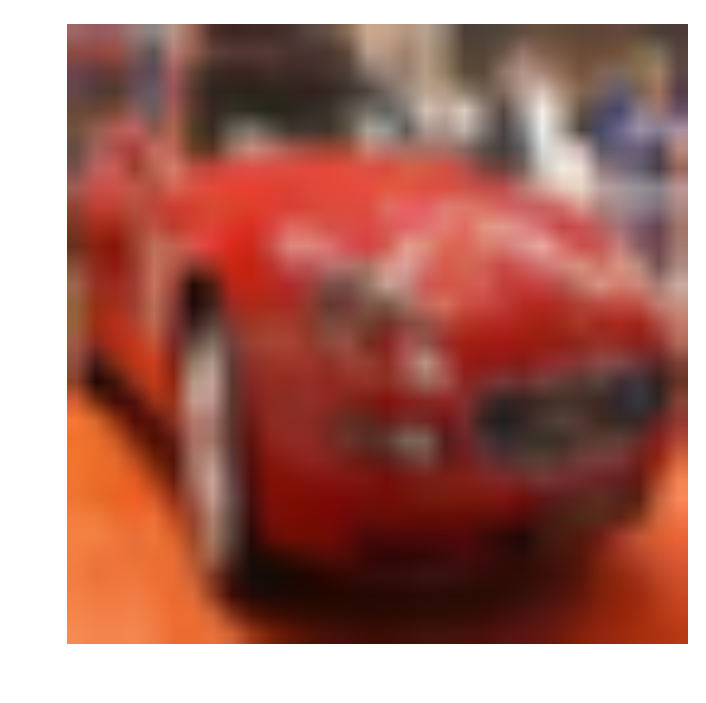

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
Implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array.

In [3]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """    
    return x/255

tests.test_normalize(normalize)

Tests Passed


### One-hot encode
Implement the `one_hot_encode` function to return the list of labels as one-hot encoded Numpy array. 

In [4]:
import tensorflow as tf
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    return np.eye(10)[x]

tests.test_one_hot_encode(one_hot_encode)

Tests Passed


## Preprocess all the data and save it
Preprocess all the CIFAR-10 data and save it to file - uses 10% of the training data for validation.

In [5]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

## Check Point

In [6]:
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability.

In [7]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a bach of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], 
                                       image_shape[2]), name = 'x')

def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.int32, (None, n_classes), name = 'y')


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32, (None), name = 'keep_prob')

tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Implement the function `conv2d_maxpool` to apply convolution then max pooling:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.

In [8]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    weight = tf.Variable(tf.truncated_normal((conv_ksize[0], conv_ksize[1], 
                                              x_tensor.get_shape().as_list()[3], 
                                              conv_num_outputs), mean = 0, stddev = 0.05))
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    
    x = tf.nn.conv2d(x_tensor, weight, strides=[1, conv_strides[0], conv_strides[1], 1], 
                     padding='SAME')
    x = tf.nn.bias_add(x, bias)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, ksize=[1, pool_ksize[0], pool_ksize[1], 1], 
                          strides=[1, pool_strides[0], pool_strides[1], 1], padding='SAME')
    return x

tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer
Implement the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.

In [9]:
from tensorflow.contrib.layers import flatten as fl

def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    return fl(x_tensor)

tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer
Implement the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*).

In [10]:
from tensorflow.contrib.layers import fully_connected
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    return fully_connected(x_tensor, num_outputs)

tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer
Implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*).

In [11]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """

    return tf.add(tf.matmul(x_tensor, tf.Variable(tf.truncated_normal(
                            [x_tensor.get_shape().as_list()[1], num_outputs]))),
                            tf.Variable(tf.zeros(num_outputs)))

tests.test_output(output)

Tests Passed


### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.

In [12]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    conv1 = conv2d_maxpool(x, 6, (5, 5), (1, 1), (2, 2), (2, 2))
    conv2 = conv2d_maxpool(conv1, 16, (5, 5), (1, 1), (2, 2), (2, 2))
    conv2 = tf.nn.dropout(conv2, keep_prob)
    conv3 = conv2d_maxpool(conv2, 32, (5, 5), (1, 1), (2, 2), (2, 2))
    fcl1 = flatten(conv3)
    fc11 = fully_conn(fcl1, 120)
    fc11 = tf.nn.relu(fc11)
    fc12 = fully_conn(fcl1, 84)
    fc12 = tf.nn.relu(fc12)
    out = output(fc12, 10)
    return out


##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization
Implement the function `train_neural_network` to do a single optimization.  The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch.

In [13]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: keep_probability})
    pass

tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats
Implement the function `print_stats` to print loss and validation accuracy.

In [14]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    validation_accuracy = session.run(accuracy, feed_dict={
        x: valid_features,
        y: valid_labels,
        keep_prob: 1})
    current_cost = session.run(cost, feed_dict={
        x: feature_batch,
        y: label_batch,
        keep_prob: 1})
    
    print('Cost: {}'.format(current_cost), 'Accuracy: {}'.format(validation_accuracy))
    pass

### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that the machine has memory for. 
* Set `keep_probability` to the probability of keeping a node using dropout

In [15]:
epochs = 25
batch_size = 64
keep_probability = 0.8

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [16]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Cost: 2.1015725135803223 Accuracy: 0.27720001339912415
Epoch  2, CIFAR-10 Batch 1:  Cost: 1.8993810415267944 Accuracy: 0.3880000114440918
Epoch  3, CIFAR-10 Batch 1:  Cost: 1.6861499547958374 Accuracy: 0.4205999970436096
Epoch  4, CIFAR-10 Batch 1:  Cost: 1.53594970703125 Accuracy: 0.45419999957084656
Epoch  5, CIFAR-10 Batch 1:  Cost: 1.4093679189682007 Accuracy: 0.48080000281333923
Epoch  6, CIFAR-10 Batch 1:  Cost: 1.2902820110321045 Accuracy: 0.49540001153945923
Epoch  7, CIFAR-10 Batch 1:  Cost: 1.2313148975372314 Accuracy: 0.49880000948905945
Epoch  8, CIFAR-10 Batch 1:  Cost: 1.1255147457122803 Accuracy: 0.5090000033378601
Epoch  9, CIFAR-10 Batch 1:  Cost: 1.0904405117034912 Accuracy: 0.527999997138977
Epoch 10, CIFAR-10 Batch 1:  Cost: 1.0521066188812256 Accuracy: 0.5198000073432922
Epoch 11, CIFAR-10 Batch 1:  Cost: 1.002420425415039 Accuracy: 0.5257999897003174
Epoch 12, CIFAR-10 Batch 1:  Cost: 0.928829

### Fully Train the Model
Try it with all five batches.

In [17]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Cost: 1.9812942743301392 Accuracy: 0.3391999900341034
Epoch  1, CIFAR-10 Batch 2:  Cost: 1.7966327667236328 Accuracy: 0.412200003862381
Epoch  1, CIFAR-10 Batch 3:  Cost: 1.3039143085479736 Accuracy: 0.46959999203681946
Epoch  1, CIFAR-10 Batch 4:  Cost: 1.549820899963379 Accuracy: 0.48980000615119934
Epoch  1, CIFAR-10 Batch 5:  Cost: 1.5781781673431396 Accuracy: 0.4950000047683716
Epoch  2, CIFAR-10 Batch 1:  Cost: 1.6529146432876587 Accuracy: 0.5045999884605408
Epoch  2, CIFAR-10 Batch 2:  Cost: 1.3937324285507202 Accuracy: 0.5181999802589417
Epoch  2, CIFAR-10 Batch 3:  Cost: 1.140406847000122 Accuracy: 0.5329999923706055
Epoch  2, CIFAR-10 Batch 4:  Cost: 1.3881638050079346 Accuracy: 0.5479999780654907
Epoch  2, CIFAR-10 Batch 5:  Cost: 1.3106333017349243 Accuracy: 0.5580000281333923
Epoch  3, CIFAR-10 Batch 1:  Cost: 1.503797173500061 Accuracy: 0.5523999929428101
Epoch  3, CIFAR-10 Batch 2:  Cost: 1.218987226486206 Accuracy: 0.573400020599

## Test Model
Test the model against the test dataset.  This will be the final accuracy.

Testing Accuracy: 0.6473925159235668



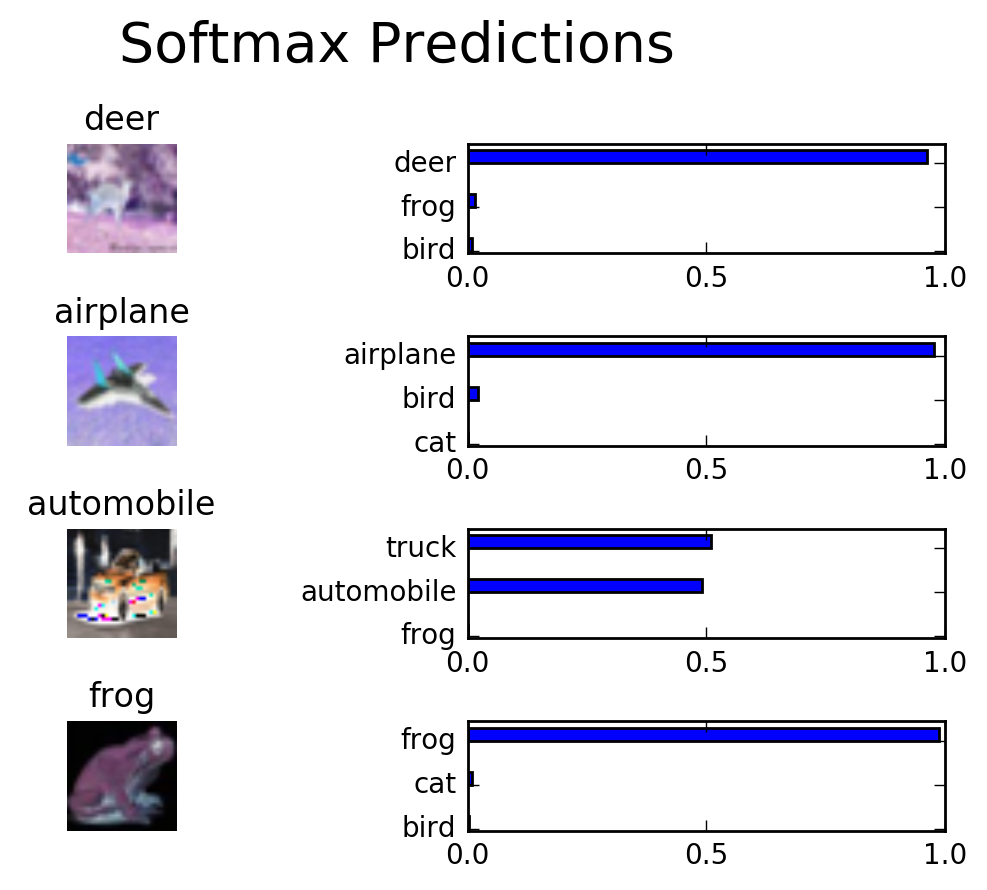

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()